# 西安城市形象建设数据处理

## 预设

#### 全局参数设置

In [139]:
ExtraDictionaryPath = 'set/dict.txt'
StopWordPath = 'set/stopwords.txt'
KeywordFilePath = 'resource/编码框架及关键词列表.xlsx'
KeywordSheetNameTopic = 'Sheet1'
KeywordSheetNameNarration = 'Sheet2'
KeywordTopNumber = 10

#### 导入模块

In [205]:
import sys
import os
import openpyxl
import csv
import re
import pandas as pd
import jieba
import jieba.posseg as psg
import matplotlib.pyplot as plt
from loguru import logger
logger.remove()
handler_id = logger.add(sys.stderr, level="DEBUG")
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimSong-Regular'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
# 显示清晰
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 函数

#### 关键词读取工具

In [214]:
# 从excel中读取内容
def get_content_from_xlsx(file_path:str, sheet_name:str,column_num:int):
    # excel表格对象 与 sheet对象
    xlsx_el = openpyxl.load_workbook(file_path)
    sheet_el = xlsx_el[sheet_name]
    # 读取
    result = []
    row_num = sheet_el.max_row
    for i in range(row_num):
        target_value = sheet_el.cell(row=i+1, column=column_num).value
        if target_value:
            result.append(str(target_value).replace(' ', ''))
    
    xlsx_el.close()
    return result

In [142]:
# 重合查找
def coincident_search(file_path, sheet_name):
    keywords_narration = get_content_from_xlsx(file_path, sheet_name, 1)
    keywords_topic = get_content_from_xlsx(file_path, sheet_name, 10)
    keywords_coincident = []
    for k in keywords_narration:
        print(k)
        if k in keywords_topic:
            print(keywords_topic.index(k))
            keywords_coincident.append(k)
    # print(keywords_narration)
    print(len(keywords_coincident),len(keywords_narration))

In [215]:
# 获取词典
def get_keywords_dict(file_path:str, sheet_name:str, column_num:int, label_diff:int=1) -> dict:
    unprocessed_keywords_list = get_content_from_xlsx(file_path, sheet_name, column_num)
    labels_list = get_content_from_xlsx(file_path, sheet_name, column_num+label_diff)
    keywords = {}
    for i, unprocessed_keywords in enumerate(unprocessed_keywords_list):
        if i > 0:
            keywords[labels_list[i]] = unprocessed_keywords.split('、')
    return keywords

#### 内容分析工具

In [245]:
# 数据清洗
def clean_data(content):
    content = re.sub('<[^<]+?>', '', str(content)
                     ).replace('\n', '').strip()  # 删除html文本
    content = re.sub(r'https://[a-zA-Z0-9.?/&=:]*',
                         '', str(content))  # 删除文本中的网址
    content = re.sub(r'http://[a-zA-Z0-9.?/&=:]*', '', content)

    return content

#分词工具
def chinese_word_cut(my_text, min_length_of_word = 3, flag_list = ['n','nz','vn']):
    jieba.load_userdict(ExtraDictionaryPath)
    jieba.initialize()
    try:
        stopword_list_unprocessed = open(StopWordPath,encoding ='utf-8')
    except:
        stopword_list_unprocessed = []
        print("error in stop_file")
    stop_word_list = []
    for line in stopword_list_unprocessed:
        line = re.sub(u'\n|\\r', '', line)
        stop_word_list.append(line)

    #jieba分词
    word_list = []
    seg_list = psg.cut(my_text)
    for seg_word in seg_list:
        # word = re.sub(u'[^\u4e00-\u9fa5]','',seg_word.word)
        word = seg_word.word
        is_unfit = False
        for stop_word in stop_word_list:
            if stop_word == word or len(word) <  min_length_of_word:     #this word is stopword
                    is_unfit = True
                    break
        if (not is_unfit) and seg_word.flag in flag_list:
            word_list.append(word)      
    return (" ").join(word_list)

# 统计词数
def get_words_count(words:str)->str:
    words_list = words.strip().split(' ')
    words_count = len(words_list)
    if words_count < 2 and not words_list[0]:
        return 0
    return words_count

# 统计词频
def statistical_word_frequency(word_list, top_num = 10):
    word_frequency_series = pd.Series(word_list.split(' '), name="count")
    word_frequency_rank = pd.DataFrame()
    word_frequency_rank['count'] = word_frequency_series.value_counts()
    total_num = word_frequency_rank['count'].size
    if total_num < top_num:
        top_num = total_num - 1
    word_frequency_rank_top = word_frequency_rank[word_frequency_rank['count']>=word_frequency_rank['count'][top_num - 1]]
    return ' '.join(word_frequency_rank_top['count'].index)

# 列表重合检测
def list_detection(list1, list2) -> bool:
    return frozenset(list1).intersection(list2)
    
# 词典检测
def dictionary_detection(words, dictionary_dict):
    if isinstance(words, str):
        words_list = words.split(' ')
    else:
        words_list = words

    analogy = ''
    all_coincident_keyword_set = set()

    for serial_number, keywords_list in dictionary_dict.items():
        coincident_keyword_set = list_detection(words_list, keywords_list)
        if len(coincident_keyword_set) > 0:
            analogy += str(serial_number) + ' '
            all_coincident_keyword_set = set.union(all_coincident_keyword_set, coincident_keyword_set)
    
    return analogy.strip() + '-' + ' '.join(all_coincident_keyword_set)

# 统计类型个数
def sum_of_types(classification_array):
    classification_unprocessed = ' '.join(classification_array).split(' ')
    labels = map(lambda s:s.strip(), filter(lambda s:s, classification_unprocessed))
    labels_count = pd.Series(labels).value_counts()
    return labels_count.index, labels_count
    

#### 工具组合

In [146]:
def get_top_keywords(content:str)->str:
    data = clean_data(content)
    word_cut = chinese_word_cut(data)
    top_keywords = statistical_word_frequency(word_cut, top_num=KeywordTopNumber)
    return top_keywords

## 数据分析

##### 词典获取

In [216]:
topic_dict = get_keywords_dict(KeywordFilePath, KeywordSheetNameTopic, 4, -2)
narration_dict = get_keywords_dict(KeywordFilePath, KeywordSheetNameNarration, 4, -2)

##### 微博数据处理代码

In [168]:

weibo = pd.read_csv("resource/西安微博.csv")
# weibo = weibo[:10]
# print(get_top_keywords(weibo['内容'][0]))
weibo['分词'] = weibo['微博正文'].apply(get_top_keywords)
weibo['代表词数'] = weibo['分词'].apply(get_words_count)
weibo['议题分类-选中词'] = weibo['分词'].apply(dictionary_detection, args=[topic_dict])
weibo['叙事分类-选中词'] = weibo['分词'].apply(dictionary_detection, args=[narration_dict])
weibo['议题分类'], weibo['议题选中词'] = weibo['议题分类-选中词'].str.split('-', 1).str
weibo['叙事分类'], weibo['叙事选中词'] = weibo['叙事分类-选中词'].str.split('-', 1).str
# print(weibo['议题分类-选中词'].head(10))
weibo.to_excel('resource/西安微博分类.xlsx', index=False)

/opt/anaconda3/envs/sklearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/envs/sklearn/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  if __name__ == '__main__':
/opt/anaconda3/envs/sklearn/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  # This is added back by InteractiveShellApp.init_path()


##### 知乎数据处理代码

In [167]:
zhihu = pd.read_csv("resource/西安回答详情.csv")
# zhihu = zhihu[:10]
# print(get_top_keywords(zhihu['内容'][0]))
zhihu['分词'] = zhihu['answer_content'].apply(get_top_keywords)
zhihu['代表词数'] = zhihu['分词'].apply(get_words_count)
zhihu['议题分类-选中词'] = zhihu['分词'].apply(dictionary_detection, args=[topic_dict])
zhihu['叙事分类-选中词'] = zhihu['分词'].apply(dictionary_detection, args=[narration_dict])
zhihu['议题分类'], zhihu['议题选中词'] = zhihu['议题分类-选中词'].str.split('-', 1).str
zhihu['叙事分类'], zhihu['叙事选中词'] = zhihu['叙事分类-选中词'].str.split('-', 1).str
# print(zhihu['选中词'].head(3))
zhihu.to_excel('resource/西安知乎分类.xlsx', index=False)

/opt/anaconda3/envs/sklearn/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/sklearn/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  # This is added back by InteractiveShellApp.init_path()


##### 豆瓣数据处理代码

In [217]:
douban = pd.read_csv("resource/豆瓣日记内容.csv")
# douban = douban[:10]
# print(get_top_keywords(douban['内容'][0]))
douban['分词'] = douban['内容'].apply(get_top_keywords)
douban['代表词数'] = douban['分词'].apply(get_words_count)
douban['议题分类-选中词'] = douban['分词'].apply(dictionary_detection, args=[topic_dict])
douban['叙事分类-选中词'] = douban['分词'].apply(dictionary_detection, args=[narration_dict])
douban['议题分类'], douban['议题选中词'] = douban['议题分类-选中词'].str.split('-', 1).str
douban['叙事分类'], douban['叙事选中词'] = douban['叙事分类-选中词'].str.split('-', 1).str
print(douban.head(3))
# douban.to_excel('resource/西安豆瓣分类.xlsx', index=False)
    

                        标题                                                 内容  \
0                 西安旅游攻略吧，  小伙伴年底要来西安玩一周！😂😂😂太高兴了。但是你要问一个西安人，西安有啥玩的，真还就半天想不...   
1  西安回民街到底该不该去，是不是专门坑游客的地方  五一到了，很多人来西安玩会有个疑惑\n回民街到底该不该去？？\n网上也是众说纷纭。\n有的人...   
2               西安怕是不能再来了~  我现在对我的西安朋友充满了怨愤。\n因为他们要是早一点告诉我西安这么好吃，我大可以在新陈代谢...   

                                     发布地址     作者  \
0  https://www.douban.com/note/820125485/  随风如愿，   
1  https://www.douban.com/note/801085769/    NPC   
2  https://www.douban.com/note/734501659/  岛上的夏奈   

                                         作者主页                  发布时间  喜欢数  \
0      https://www.douban.com/people/Ch95134/  2021-11-21 08:14:20    64   
1    https://www.douban.com/people/nnnpppccc/  2021-04-24 15:58:39   186   
2  https://www.douban.com/people/ChannaDisco/  2019-09-16 18:42:50   758   

    收藏数  转发数                                                 分词  代表词数  \
0   144   18  博物馆 本地人 文公庙 电视塔 未央区 森林公园 示意图 历史博物馆 专业人士 客运站 猪大...    31   
1   442   38  本

/opt/anaconda3/envs/sklearn/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/opt/anaconda3/envs/sklearn/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  if __name__ == '__main__':


## 数据可视化

### 议题分类统计

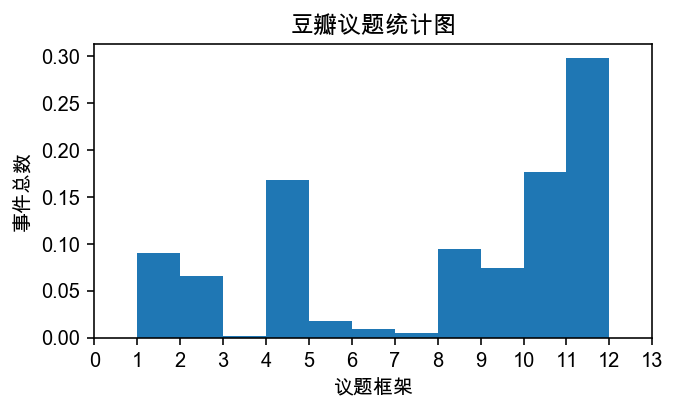

In [206]:
fig, ax = plt.subplots(figsize=(5, 2.7))
x = ' '.join(douban['议题分类'].array).split(' ')
x = list(map(lambda s:int(s), filter(lambda s:s, x)))
# print(x)
num_bins = range(13)
n, bins, patches = ax.hist(x, num_bins[1:], density=True)
narration_tick_labels = ['积极', '消极', '事件', '细节']
ax.set_xticks(range(14))
# ax.set_xticklabels(narration_tick_labels)
ax.set_xlabel('议题框架')
ax.set_ylabel('事件总数')
ax.set_title('豆瓣议题统计图')
plt.show()

### 叙事分类统计

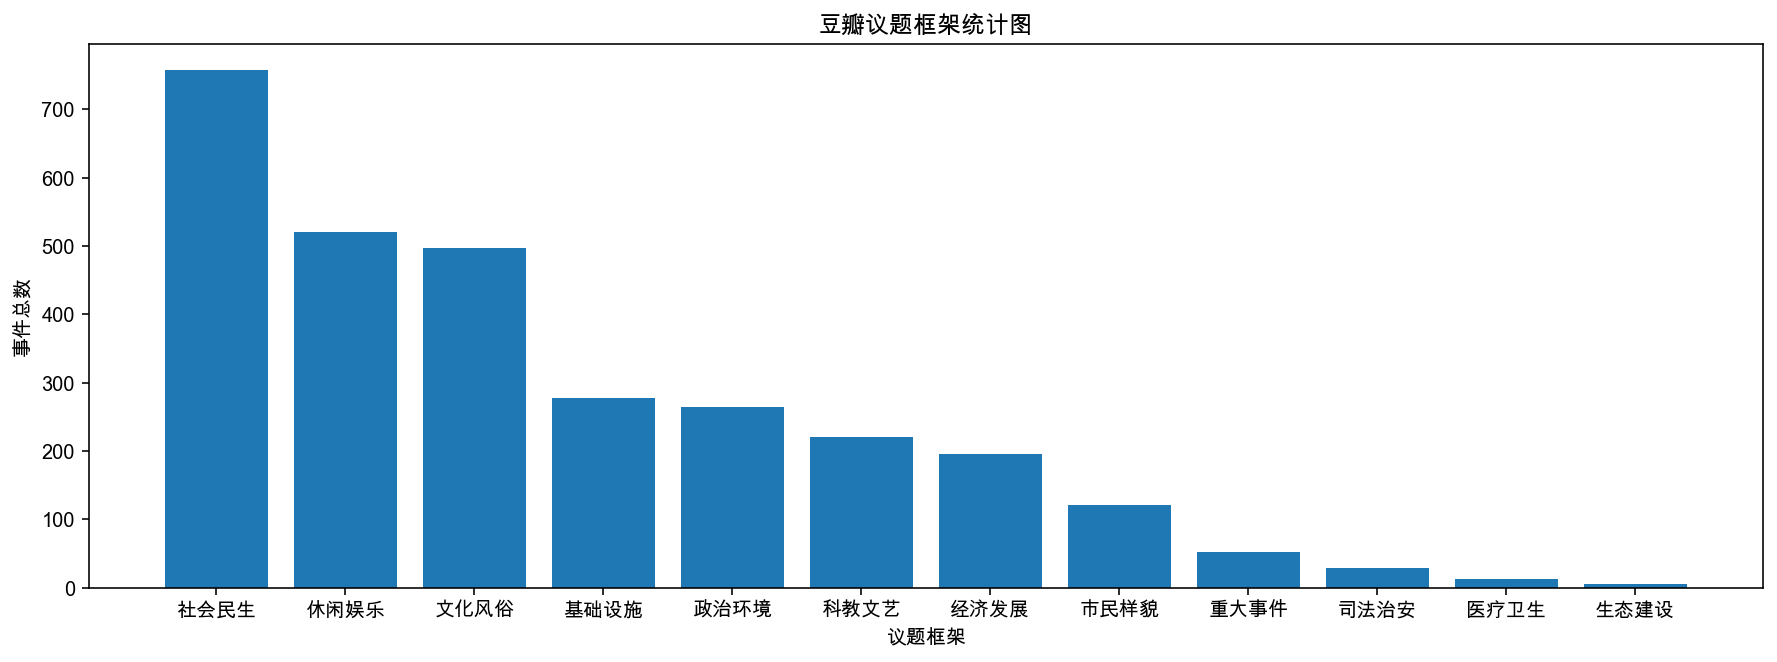

In [260]:
fig, ax = plt.subplots(figsize=(15, 5))
labels, counts = sum_of_types(douban['议题分类'].array)
bar_labels = ['red', 'blue', 'green', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']
ax.bar(labels, counts)
# ax.bar(labels, counts, label=bar_labels, color=bar_colors)
ax.set_xlabel('议题框架')
ax.set_ylabel('事件总数')
ax.set_title('豆瓣议题框架统计图')
plt.show()

## playground

In [247]:
# print(sum_of_types(douban['叙事分类'].array))
print(sum_of_types(douban['议题分类'].array))

(Index(['社会民生', '休闲娱乐', '文化风俗', '基础设施', '政治环境', '科教文艺', '经济发展', '市民样貌', '重大事件',
       '司法治安', '医疗卫生', '生态建设'],
      dtype='object'), 社会民生    758
休闲娱乐    521
文化风俗    497
基础设施    278
政治环境    265
科教文艺    220
经济发展    195
市民样貌    121
重大事件     52
司法治安     28
医疗卫生     13
生态建设      5
dtype: int64)
